# This notebook explores the use of an RNN model for predicting beaching locations with the Asia watershed

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tqdm

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 2.5)

In [3]:
# load data
Asia = pd.read_csv('selected_clusters/cluster_16_data.csv').drop(columns = 'HDBSCAN')

## Let's look at our dataset: Asia Beaching Watershed

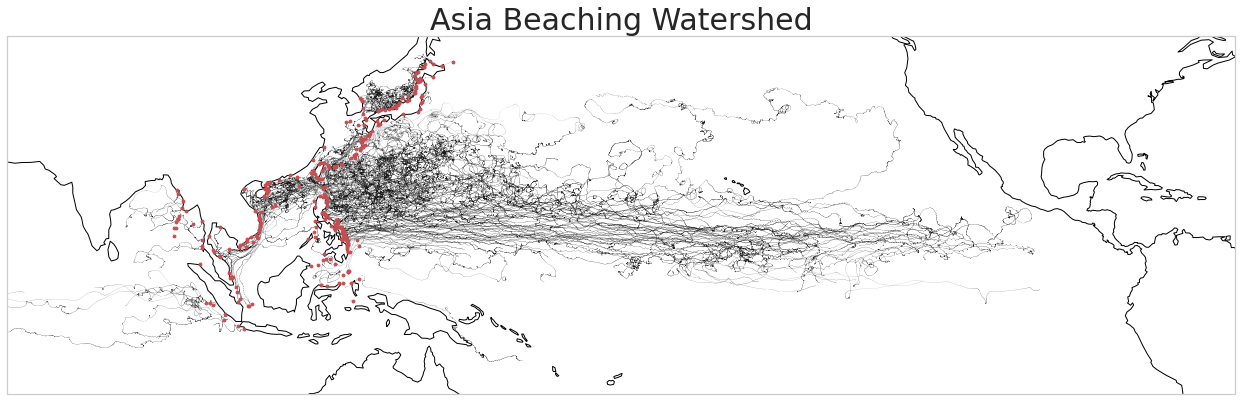

In [4]:
# take a look at the drifter trajectories and beaching locations
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = ax.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)

ax.scatter(beaching_points['lon'], beaching_points['lat'], color='r', transform=ccrs.PlateCarree(), s = 8)  # Specify the coordinate reference system

plt.title('Asia Beaching Watershed', fontsize = 30)
plt.show()

## Let's prepare and clean our data by: 
## 1. Applying a coordinate transform and normalizing 
## 2. Converting into tensors and padding 
## 3. Splitting into train, test, validation, and target
##
### Let's start with 1.

We first need to solve the spatial problem inherent to latitude/longitude coordinate data. The distance between one degree of longitude and another is greatest at the equator and smallest at the poles: in fact, as one approaches the poles, the distance in a degree of longitude gets exponentially small. Another problem is that -180 degrees longitude is equal to 180 degrees longitude, this is far from helpful to a neural network. How do we normalize this kind of data? Let's apply a coordinate transform, converting latitude and longitude to the x, y, z coordinates of a sphere (we make the assumption the Earth is a perfect sphere, it isn't, but this shouldn't impact our results in any significant way). The next block of code defines a function to achieve this transformation and shows a 2-d lat/lon map before and 3-d x,y,z sphere after.

In [5]:
# we define a function to transform lat/lon to x,y,z and normalize while we're at it
def coord_transform_normalize(lat_list, lon_list, scaler):
    
    # convert to radians for use of np.cos, np.sin
    lats_r, lons_r = np.radians(lat_list), np.radians(lon_list)
    
    # transform lat/lon to x, y, z
    x = np.cos(lons_r) * np.cos(lats_r)
    y = np.sin(lons_r) * np.cos(lats_r) 
    z = np.sin(lats_r) 
    
    # stack x,y,z coords
    xyz_coords = np.column_stack((x, y, z))
    
    # fit scaler to the coords and apply normalization
    norm_xyz_coords = scaler.fit_transform(xyz_coords)
    
    # split back into x,y,z
    norm_x, norm_y, norm_z = np.hsplit(norm_xyz_coords, 3)

    return norm_x, norm_y, norm_z

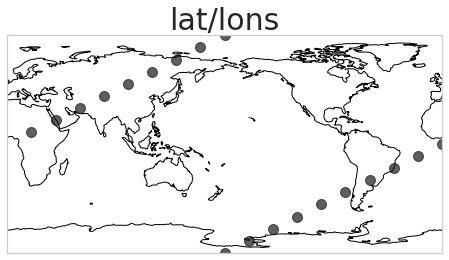

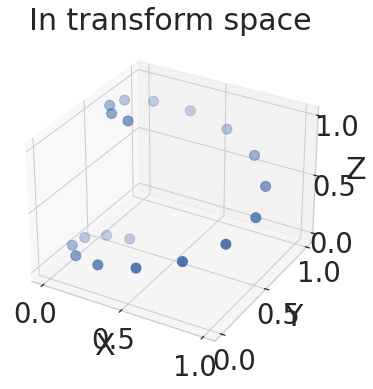

In [6]:
# now we apply this transform to some toy lat/lons:
toy_latitudes = np.array([-90, -80, -70, -60, -50, -40, -30, -20, -10, 0, 
                          10, 20, 30, 40, 50, 60, 70, 80, 90])

toy_longitudes = np.array([-180, -160, -140, -120, -100, -80, -60, -40, -20, 0, 
                           20, 40, 60, 80, 100, 120, 140, 160, 180])
# initialize MinMaxScaler
toy_scaler = MinMaxScaler()

toy_x, toy_y, toy_z = coord_transform_normalize(toy_latitudes, toy_longitudes, toy_scaler)

# let's plot both x,y,z and lat, lon to visualize how the transform works:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()
point_size = 100
toy_scatter =ax.scatter(
    toy_longitudes,
    toy_latitudes,
    marker='o',
    c='k',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)
plt.title('lat/lons')
plt.show()

# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_x, toy_y, toy_z, s = 100)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

In [7]:
# let's apply the coordinate transform and normalization
# initialize MinMaxScaler for coords
coord_scaler = MinMaxScaler()
# apply coordinate transform and normalization to coords
Asia_x, Asia_y, Asia_z = coord_transform_normalize(Asia['lat'], Asia['lon'], coord_scaler)

# initialize MinMaxScaler for time_to_beach
#time_to_beach_scaler = MinMaxScaler()
#Asia_time_to_beach_norm = time_to_beach_scaler.fit_transform(np.array(Asia['time_to_beach']).reshape(-1,1))

Asia_norm = Asia.drop(columns = ['lat', 'lon','time_to_beach']).assign(x = Asia_x, y = Asia_y, z = Asia_z)

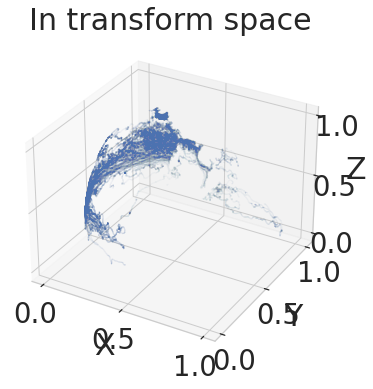

In [8]:
# taking a look at the output of coordinate transformation and normalization:
# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Asia_norm['x'][::10], Asia_norm['y'][::10], Asia_norm['z'][::10], s = 0.0005) # every 10th data point
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

### 2. Let's continue by converting to tensors and padding

In [9]:
# group Asia_xyz_norm watershed by unique id and order each row as 'unique id' 
# then subsequent feature columns consisting of lists
Asia_by_traj = Asia_norm.groupby('id').agg(lambda x: x.tolist()).reset_index() 

# remove trajectories with less than 1000 trajectories
Asia_by_traj['Traj_Length'] = Asia_by_traj['time'].apply(len)
Asia_by_traj = Asia_by_traj[Asia_by_traj['Traj_Length'] >= 1000].drop(columns='Traj_Length')

# FOR MODEL DEBUGGING-------------------------------------------------------------------
#Asia_by_traj = Asia_by_traj[100:130]

# define targets as beaching coords (last coords when time_to_beach = 0)
target_x = torch.tensor([x_list[-1] for x_list in Asia_by_traj['x']])
target_y = torch.tensor([y_list[-1] for y_list in Asia_by_traj['y']])
target_z = torch.tensor([z_list[-1] for z_list in Asia_by_traj['z']])

# combine normalized target tensors for splitting
all_targets = torch.stack((target_x, target_y, target_z), dim = 1)

In [10]:
# generate feature tensors with padding
# first get data into x,y,z arrays and apply rolling window average

# reduce the number of data by taking windows of some length and taking the average
def window_avg(data, window_size):
    subsets = [data[i:i+window_size] for 
               i in range(0, len(data), window_size)]
    averaged_data = [np.mean(subsets[i]) for i, _ in enumerate (subsets)]
    return averaged_data

# get data from dataframe and apply reduction
window_size = 100# set window_size
x_avg = [window_avg(x_list, window_size) for x_list in Asia_by_traj['x']]
y_avg = [window_avg(y_list, window_size) for y_list in Asia_by_traj['y']]
z_avg = [window_avg(z_list, window_size) for z_list in Asia_by_traj['z']]

# define the lengths of sequences before padding
input_lengths = [len(x_seq) for x_seq in x_avg]

# convert averaged arrays to tensors and apply padding
padded_x = nn.utils.rnn.pad_sequence([torch.tensor(x_seq) for x_seq in x_avg], batch_first = True)
padded_y = nn.utils.rnn.pad_sequence([torch.tensor(y_seq) for y_seq in y_avg], batch_first = True)
padded_z = nn.utils.rnn.pad_sequence([torch.tensor(z_seq) for z_seq in z_avg], batch_first = True)

# combine the padded tensors for splitting
all_data = torch.stack((padded_x, padded_y, padded_z), dim = 2)

### Let's take a quick break from data prep and define our vanilla RNN model and set hyperparameters

In [15]:
# let's define our vanilla RNN model:
class drifter_vanilla_RNN(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, nonlinearity, output_size):

        super(drifter_vanilla_RNN, self).__init__()

        # define rnn cell with nonlinearity
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                                num_layers = num_layers, nonlinearity = nonlinearity) # maybe try LSTM/GRU later

        # define fully connected layer to predict next part of target sequence
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, padded_input, input_lengths, hidden_state):
        # pack padded sequence
        packed_input = rnn_utils.pack_padded_sequence(padded_input, input_lengths, batch_first=True, enforce_sorted=False)
        
        # get output and hidden state through rnn
        packed_output, hidden_state = self.rnn(packed_input, hidden_state)
        
        # unpack output
        output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # extract the output from the last time step for each sequence (lat/lon of beaching)
        final_lat_lon = output[:, -1, :]
        
        # predict the final beaching coordinates
        output = self.fc(final_lat_lon)

        return output, hidden_state.detach()

In [16]:
# define hyperparameters

# Fix random seed
torch.manual_seed(42)

# Define RNN network:
rnn = drifter_vanilla_RNN(input_size = 3, hidden_size = 1028, num_layers = 3,
              output_size = 3, nonlinearity = 'relu')#.cuda()

# Define learning rate, epochs, and batchsize
lr = 0.001
epochs = 50
batchsize = 100

# define loss function
loss_func = torch.nn.MSELoss() # for regression

# use Adam optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr = lr)

# track training loss and validation loss
train_loss_list = []
val_loss_list = []

### 3. For the last step of data prep, let's split into train, test, validation, and target, let's also split training input and targets into batches

In [17]:
# split data and input lengths into training and remaining (for validation and testing)
train_data, remaining_data, train_targets, remaining_targets, train_lengths, remaining_lengths = train_test_split(
    all_data, all_targets, input_lengths, train_size = 140, random_state = 42) # 175

# split the remaining data and input lengths into validation and test sets
val_data, test_data, val_targets, test_targets, val_lengths, test_lengths = train_test_split(
    remaining_data, remaining_targets, remaining_lengths, test_size = 20, random_state = 42) # 75

# split training data and lengths into batches
train_data_batch = torch.split(train_data, batchsize)
train_lengths_batch = torch.split(torch.tensor(train_lengths), batchsize)

# split training targets into batches
train_targets_batch = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of batches in the training set
batch_split_num = len(train_data_batch)

## Now, we train the model

In [18]:
# Let's train our model now (tqdm creates nice progress bar)
for epoch in tqdm.trange(epochs):
    
    # iterate through each batch
    for batch in range(batch_split_num):
    
    
        # initialize hidden_state for each epoch:
        hidden_state = None

        #separate learning for each epoch by initializing optimzer each epoch
        optimizer.zero_grad()

        # pass training inputs through model to get outputs
        train_outputs, hidden_state = rnn(train_data_batch[batch].float(), train_lengths_batch[batch], hidden_state)

        # compute loss
        train_loss = loss_func(train_outputs, train_targets_batch[batch])#.to(device))

        # print training loss
        print('training loss: '+ str(train_loss.item()))

        # save loss for each epoch
        train_loss_list.append(train_loss.item())

        # determine changes needed for each weight/bias for next epoch
        train_loss.backward()

        # apply changes to weights/biases
        optimizer.step()

    # compute validation loss for each epoch: 
    # validation tests model against non-training data to ensure model isn't overfitting to training data
    with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose

        # initialize hidden_state for each epoch:
        hidden_state = None
        
        # apply model to validation data
        val_outputs, val_hidden_state = rnn(val_data.float(), val_lengths, hidden_state)#.to(device))

        # compute validation loss
        val_loss = loss_func(val_outputs, val_targets)

        # save validation loss for each epoch
        val_loss_list.append(val_loss.item()) 

  0%|          | 0/50 [00:00<?, ?it/s]

training loss: 0.4400038719177246
training loss: 0.4303254187107086


  2%|▏         | 1/50 [00:26<21:25, 26.23s/it]

training loss: 0.43425777554512024
training loss: 0.4239947497844696


  4%|▍         | 2/50 [00:53<21:32, 26.92s/it]

training loss: 0.4315803647041321
training loss: 0.4212180972099304


  6%|▌         | 3/50 [01:20<21:06, 26.94s/it]

training loss: 0.42816397547721863
training loss: 0.41755929589271545


  8%|▊         | 4/50 [01:48<20:53, 27.24s/it]

training loss: 0.4256415367126465
training loss: 0.4145307242870331


 10%|█         | 5/50 [02:14<20:12, 26.95s/it]

training loss: 0.4233188331127167
training loss: 0.4124778211116791


 12%|█▏        | 6/50 [02:41<19:43, 26.90s/it]

training loss: 0.4209461212158203
training loss: 0.4100935757160187


 14%|█▍        | 7/50 [03:07<19:01, 26.54s/it]

training loss: 0.4186367690563202
training loss: 0.40790340304374695


 16%|█▌        | 8/50 [03:26<16:54, 24.15s/it]

training loss: 0.41636019945144653
training loss: 0.4055452048778534


 18%|█▊        | 9/50 [03:50<16:28, 24.11s/it]

training loss: 0.4141399562358856
training loss: 0.40335261821746826


 20%|██        | 10/50 [04:12<15:42, 23.56s/it]

training loss: 0.41185247898101807
training loss: 0.40110406279563904


 22%|██▏       | 11/50 [04:36<15:19, 23.57s/it]

training loss: 0.4095669388771057
training loss: 0.39896491169929504


 24%|██▍       | 12/50 [04:59<14:48, 23.38s/it]

training loss: 0.40729472041130066
training loss: 0.3967449963092804


 26%|██▌       | 13/50 [05:22<14:23, 23.33s/it]

training loss: 0.4050627052783966
training loss: 0.394585520029068


 28%|██▊       | 14/50 [05:44<13:47, 22.97s/it]

training loss: 0.4028300642967224
training loss: 0.3923932909965515


 30%|███       | 15/50 [06:07<13:22, 22.94s/it]

training loss: 0.400612473487854
training loss: 0.3902449607849121


 32%|███▏      | 16/50 [06:30<12:58, 22.89s/it]

training loss: 0.39841699600219727
training loss: 0.3880667984485626


 34%|███▍      | 17/50 [06:57<13:20, 24.26s/it]

training loss: 0.39623337984085083
training loss: 0.38593223690986633


 36%|███▌      | 18/50 [07:24<13:15, 24.87s/it]

training loss: 0.3940480351448059
training loss: 0.38380369544029236


 38%|███▊      | 19/50 [07:50<13:02, 25.25s/it]

training loss: 0.3918610215187073
training loss: 0.38170546293258667


 40%|████      | 20/50 [08:16<12:49, 25.64s/it]

training loss: 0.3896908164024353
training loss: 0.37959760427474976


 42%|████▏     | 21/50 [08:42<12:22, 25.60s/it]

training loss: 0.3875388205051422
training loss: 0.3775039315223694


 44%|████▍     | 22/50 [09:08<12:05, 25.92s/it]

training loss: 0.3853984773159027
training loss: 0.3754163384437561


 46%|████▌     | 23/50 [09:35<11:48, 26.25s/it]

training loss: 0.3832681477069855
training loss: 0.37334343791007996


 48%|████▊     | 24/50 [10:02<11:26, 26.42s/it]

training loss: 0.38115283846855164
training loss: 0.37127283215522766


 50%|█████     | 25/50 [10:29<11:01, 26.45s/it]

training loss: 0.3790486454963684
training loss: 0.3692200481891632


 52%|█████▏    | 26/50 [10:55<10:34, 26.42s/it]

training loss: 0.3769497573375702
training loss: 0.36718130111694336


 54%|█████▍    | 27/50 [11:21<10:06, 26.38s/it]

training loss: 0.3748575747013092
training loss: 0.3651568293571472


 56%|█████▌    | 28/50 [11:48<09:42, 26.48s/it]

training loss: 0.3727785348892212
training loss: 0.36313673853874207


 58%|█████▊    | 29/50 [12:12<09:00, 25.72s/it]

training loss: 0.37071365118026733
training loss: 0.3611268103122711


 60%|██████    | 30/50 [12:35<08:18, 24.92s/it]

training loss: 0.3686600625514984
training loss: 0.35912689566612244


 62%|██████▏   | 31/50 [12:59<07:49, 24.70s/it]

training loss: 0.36661678552627563
training loss: 0.3571382462978363


 64%|██████▍   | 32/50 [13:22<07:13, 24.09s/it]

training loss: 0.36458534002304077
training loss: 0.35515815019607544


 66%|██████▌   | 33/50 [13:44<06:40, 23.59s/it]

training loss: 0.3625643849372864
training loss: 0.3531906306743622


 68%|██████▊   | 34/50 [14:12<06:35, 24.72s/it]

training loss: 0.3605518341064453
training loss: 0.35123565793037415


 70%|███████   | 35/50 [14:32<05:51, 23.44s/it]

training loss: 0.3585483729839325
training loss: 0.34929168224334717


 72%|███████▏  | 36/50 [14:54<05:22, 23.06s/it]

training loss: 0.35655683279037476
training loss: 0.34735554456710815


 74%|███████▍  | 37/50 [15:21<05:14, 24.19s/it]

training loss: 0.3545773923397064
training loss: 0.3454291522502899


 76%|███████▌  | 38/50 [15:43<04:43, 23.62s/it]

training loss: 0.3526085913181305
training loss: 0.34351328015327454


 78%|███████▊  | 39/50 [16:10<04:28, 24.37s/it]

training loss: 0.3506499230861664
training loss: 0.34160786867141724


 80%|████████  | 40/50 [16:30<03:51, 23.15s/it]

training loss: 0.34870192408561707
training loss: 0.3397122323513031


 82%|████████▏ | 41/50 [16:56<03:36, 24.07s/it]

training loss: 0.3467640280723572
training loss: 0.3378277122974396


 84%|████████▍ | 42/50 [17:23<03:18, 24.85s/it]

training loss: 0.34483546018600464
training loss: 0.3359541594982147


 86%|████████▌ | 43/50 [17:50<02:57, 25.42s/it]

training loss: 0.34291693568229675
training loss: 0.33409035205841064


 88%|████████▊ | 44/50 [18:15<02:33, 25.52s/it]

training loss: 0.3410094976425171
training loss: 0.33223554491996765


 90%|█████████ | 45/50 [18:41<02:07, 25.56s/it]

training loss: 0.339112788438797
training loss: 0.330390602350235


 92%|█████████▏| 46/50 [19:05<01:40, 25.22s/it]

training loss: 0.33722618222236633
training loss: 0.3285558819770813


 94%|█████████▍| 47/50 [19:26<01:11, 23.84s/it]

training loss: 0.33534955978393555
training loss: 0.3267310559749603


 96%|█████████▌| 48/50 [19:53<00:49, 24.82s/it]

training loss: 0.3334830105304718
training loss: 0.3249160945415497


 98%|█████████▊| 49/50 [20:19<00:25, 25.09s/it]

training loss: 0.3316262662410736
training loss: 0.3231114149093628


100%|██████████| 50/50 [20:45<00:00, 24.92s/it]


final training loss: 0.3231114149093628
final validation loss: 0.19678455591201782


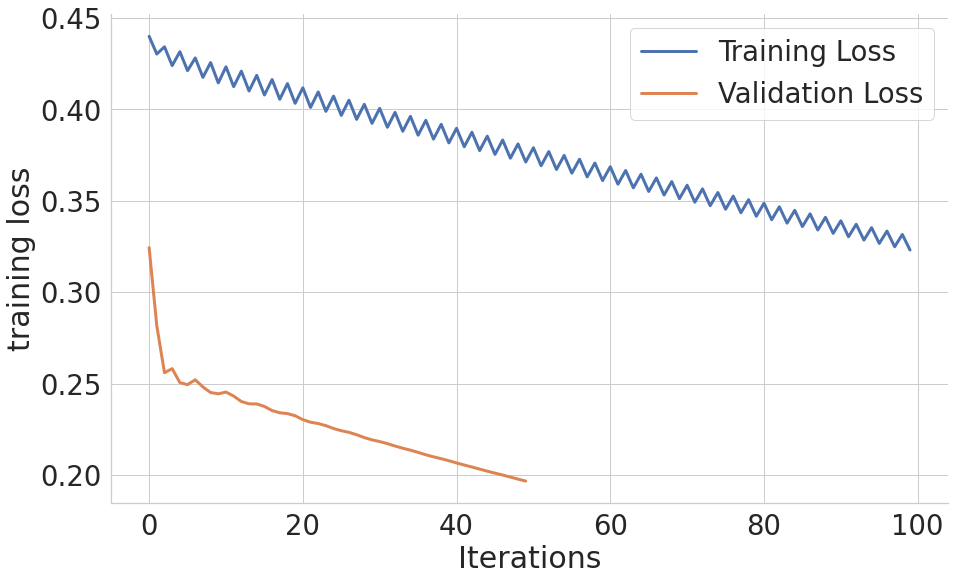

In [19]:
# let's visualize the training and validation loss
print('final training loss: '+ str(train_loss_list[-1]))
print('final validation loss: '+ str(val_loss_list[-1]))

plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(val_loss_list, linewidth = 3, label = 'Validation Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

## let's test our model with our test data now!

In [20]:
# activate no_grad() since we aren't performing backprop: testing not training
with torch.no_grad():
    
    # initialize hidden state for the encoder:
    hidden_state = None
    
    # pass training inputs through model to get outputs
    test_outputs, hidden_state = rnn(test_data.float(), test_lengths, hidden_state)
    
    # compute loss
    test_loss = loss_func(test_outputs, test_targets)
print(test_loss.item())

0.3236958086490631


### to convert back to lat/lon coordinates and visualize where the model predicted beaching, we need to perform the inveres of the coord_transform_normalize function on the test output

In [21]:
# we define a function to transform normalized x,y,z output to lat/lon coordinates
def inverse_coord_transform_normalize(model_outputs):
    
    # convert from tensor to list of lists
    model_outputs_list = model_outputs.tolist()
    
    # undo MinMaxScaler normalization
    model_outputs_denorm = [coord_scaler.inverse_transform(np.array(xyz_norm_coords).reshape(-1, 3))
        for xyz_norm_coords in model_outputs_list]
    
    x = [coord[0][0] for coord in model_outputs_denorm]
    y = [coord[0][1] for coord in model_outputs_denorm]
    z = [coord[0][2] for coord in model_outputs_denorm]
    
    lons = np.degrees(np.arctan2(y, x))
    lats = np.degrees(np.arcsin(z))

    return lats, lons

In [24]:
lat_outputs, lon_outputs

(array([-9.24816024, -9.24816024, -9.24816024, -9.24816024, -9.24816024,
        -9.24816024, -9.24816024, -9.24816024, -9.24816024, -9.24816024,
        -9.24816024, -9.24816024, -9.24816024, -9.24816024, -9.24816024,
        -9.24816024, 23.21777654, -9.24816024, -9.24816024, -9.24816024]),
 array([-132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
        -132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
        -132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
        -132.9596486 , -132.9596486 , -132.9596486 , -132.9596486 ,
         118.94345477, -132.9596486 , -132.9596486 , -132.9596486 ]))

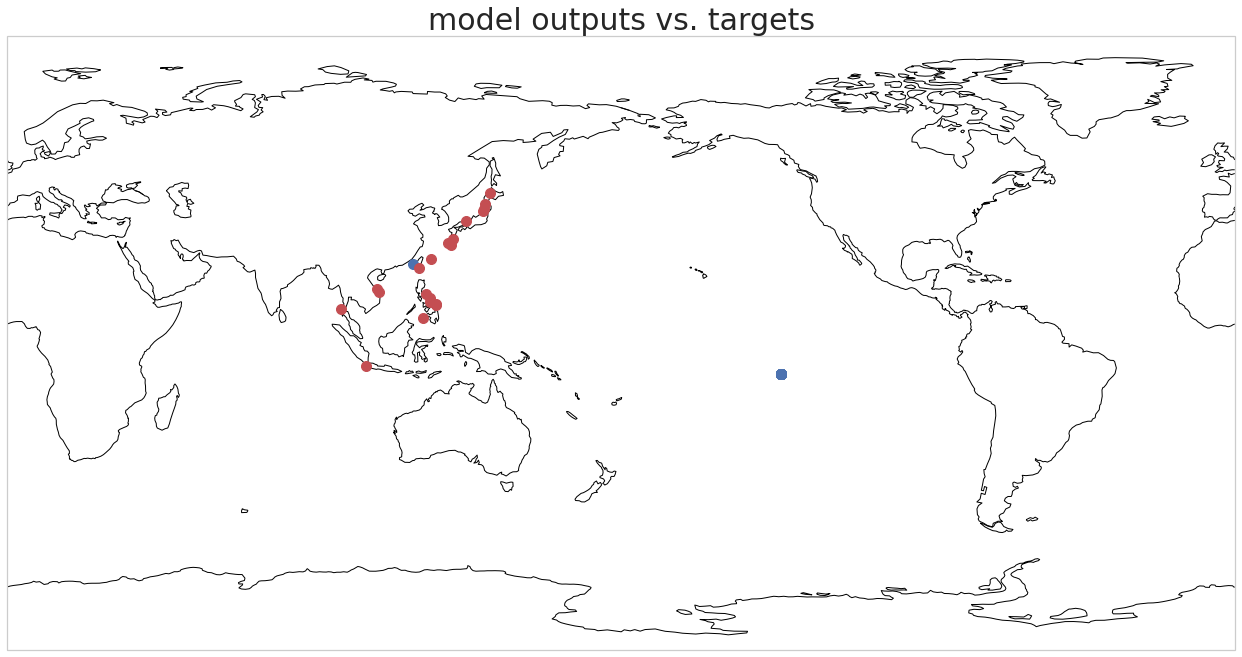

In [22]:
# convert x,y,z normalized outputs to denormalized lat/lon coords
lat_outputs, lon_outputs = inverse_coord_transform_normalize(test_outputs)

# convert x,y,z normalized targets to denormalized lat/lon coords
lat_targets, lon_targets = inverse_coord_transform_normalize(test_targets)

# plot model outputs vs. targets
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 100

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
# model outputs
scatter_targets = ax.scatter(
    lon_outputs,
    lat_outputs,
    marker='o',
    c='b',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

# targets
scatter_targets = ax.scatter(
    lon_targets,
    lat_targets,
    marker='o',
    c='r',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

plt.title('model outputs vs. targets', fontsize = 30)
plt.show()